In [1]:
import os
from os.path import join as opj

import numpy as np
from omegaconf import OmegaConf
from copy import deepcopy
import torch
from datetime import datetime
from matplotlib import pyplot as plt

from utils.gumbel_softmax import gumbel_softmax
from utils.misc import reproduc, plot_causal_matrix, plot_causal_matrix_in_training, calc_and_log_metrics
from utils.logger import MyLogger

from data.simu_data import simulate_var, simulate_random_var, load_dream_data, simulate_lorenz_96

import cuts_plus

In [2]:
opt = OmegaConf.load("opt/lorenz_example.yaml")
device = "cuda"

reproduc(**opt.reproduc)
timestamp = datetime.now().strftime("_%Y_%m%d_%H%M%S_%f")
opt.task_name += timestamp
proj_path = opj(opt.dir_name, opt.task_name)
log = MyLogger(log_dir=proj_path, **opt.log)
log.log_opt(opt)

In [4]:
opt_data = opt.data

if opt_data.name == "uniform_var":
    data, beta, true_cm = simulate_var(**opt_data.param)
elif opt_data.name == "random_var":
    data, true_cm = simulate_random_var(**opt_data.param)
elif opt_data.name == "lorenz_96":
    data, true_cm = simulate_lorenz_96(**opt_data.param)
elif opt_data.name == "dream":
    data, true_cm = load_dream_data(**opt_data.param)
else:
    raise NotImplementedError

print("Data shape: ", data.shape)

Data shape:  (1000, 128)


In [5]:
p_block = opt_data.missing.params.p_block
p_noise = opt_data.missing.params.p_noise
max_seq = opt_data.missing.params.max_seq
min_seq = opt_data.missing.params.min_seq

np.random.seed(opt_data.seed)
rand = np.random.random
randint = np.random.randint

# Generate random blocks noise
init_mask = rand(data.shape) < p_block
for col in range(init_mask.shape[1]):
    idxs = np.flatnonzero(init_mask[:, col])
    if not len(idxs):
        continue
    fault_len = min_seq
    if max_seq > min_seq:
        fault_len = fault_len + int(randint(max_seq - min_seq))
    idxs_ext = np.concatenate([np.arange(i, i + fault_len) for i in idxs])
    idxs = np.unique(idxs_ext)
    idxs = np.clip(idxs, 0, init_mask.shape[0] - 1)
    init_mask[idxs, col] = True

# Generate random noise
eval_mask = init_mask | (rand(init_mask.shape) < p_noise)
mask = 1 - eval_mask

sampled_data = data * mask
print("Sampled data MSE: ", np.mean((sampled_data - data)**2))

Sampled data MSE:  7.78678763000192


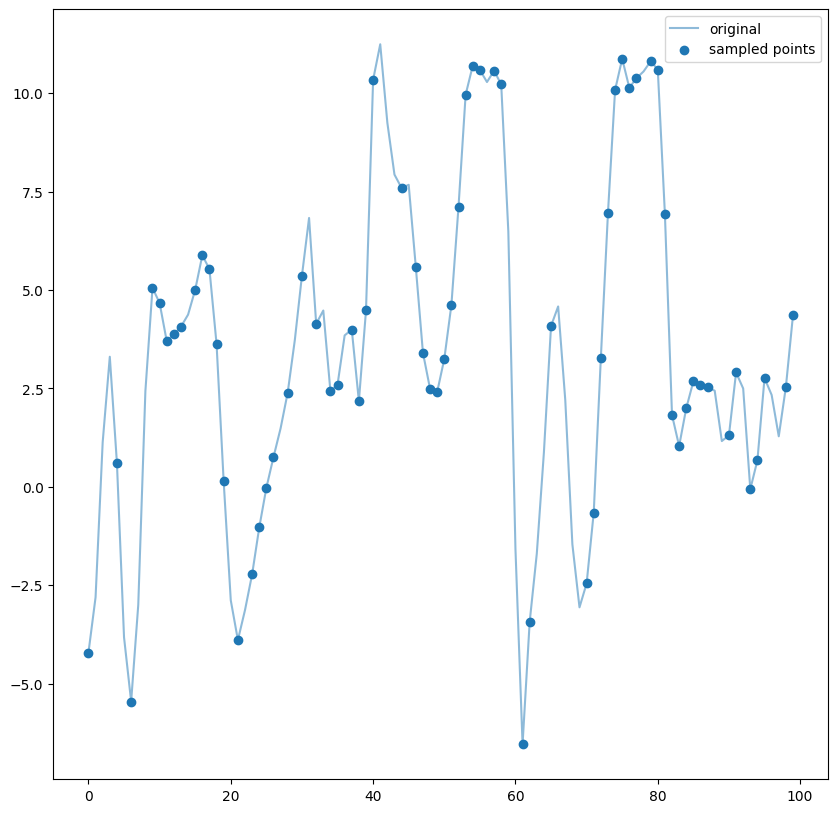

In [6]:
fig = plt.figure(figsize=[10,10])
plt.plot(np.arange(0, 100, 1), data[:100,1], label="original", alpha=0.5)
plt.scatter(np.argwhere(mask[:100,1]), data[np.argwhere(mask[:100,1]),1], label="sampled points")
plt.legend()
plt.show()

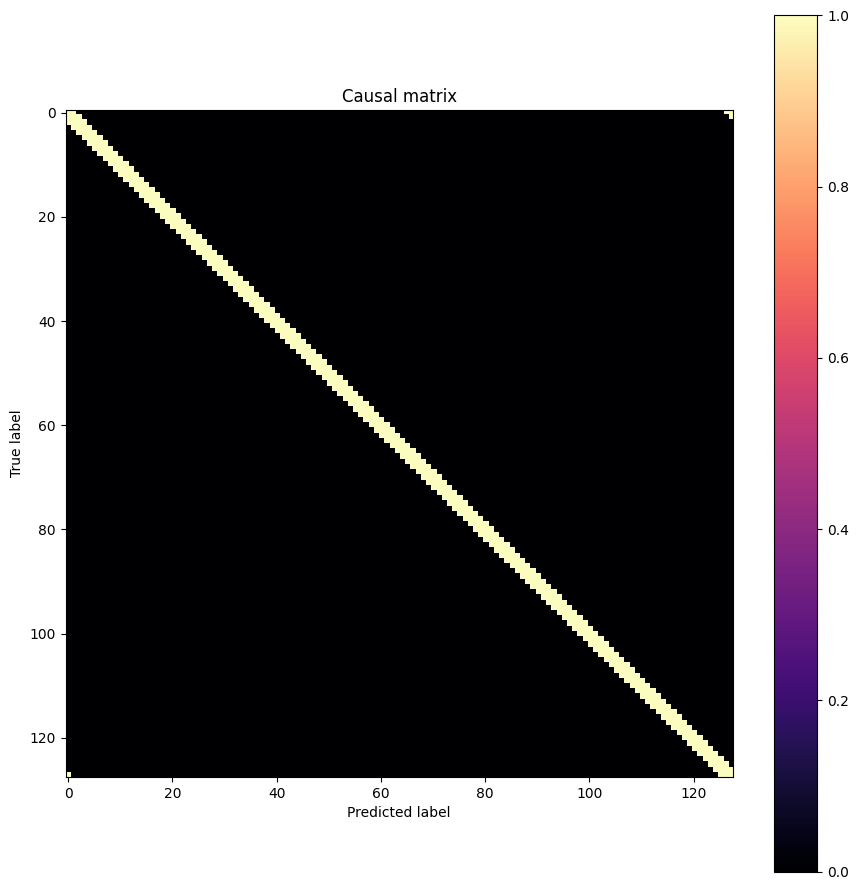

In [7]:
sub_cg = plot_causal_matrix(true_cm, figsize=[9, 9], vmin=0, vmax=1)
plt.show()

In [8]:
sota_opt = opt.sota
graph = cuts_plus.main(data, mask, true_cm, sota_opt.cuts_plus, log, device=device)

n_groups:  32
Using masked supervision for data prediction (masked_before_100)......


 31%|███▏      | 20/64 [00:17<00:40,  1.07it/s, S1 loss=0.53, spr=IDLE, auc=0.9933]

Data update started!


100%|██████████| 64/64 [00:57<00:00,  1.12it/s, S2 loss=0.54, spr=0.59, auc=0.9983]


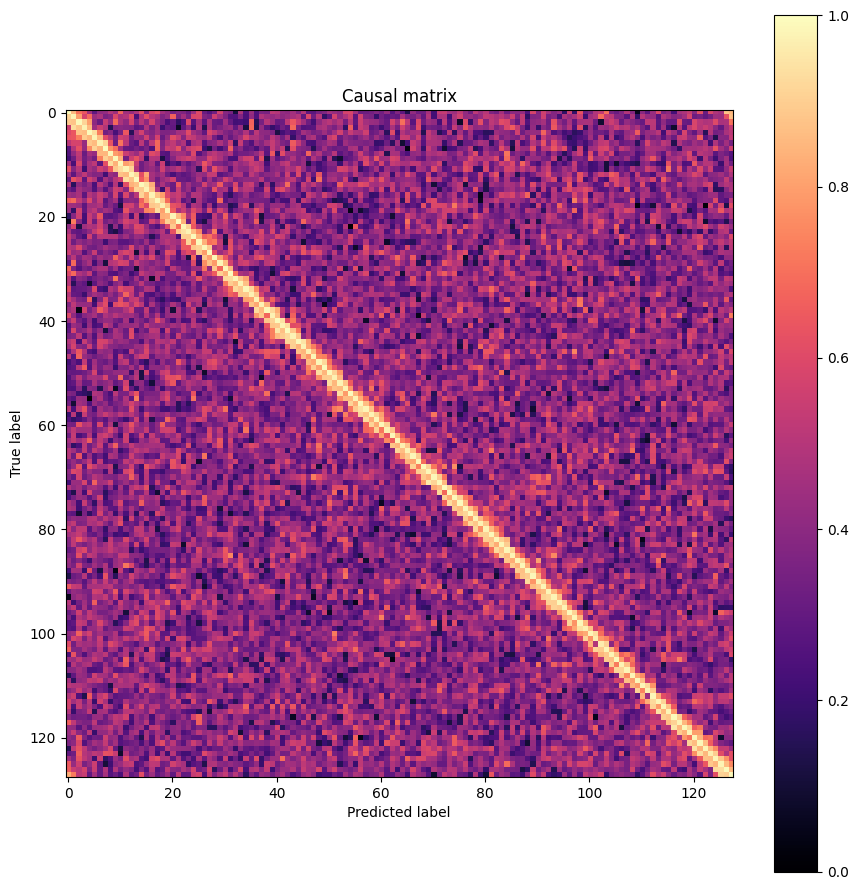

In [9]:
graph = (graph - np.min(graph)) / (np.max(graph) - np.min(graph))
sub_cg = plot_causal_matrix(graph, figsize=[9, 9], vmin=0, vmax=1)
plt.show()